<a href="https://www.kaggle.com/turksoyomer/deep-learning-methods-on-malaria-cell-images?scriptVersionId=89546770" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Contents

**1. Introduction**

**2. Importing Libraries**

**3. Reading and Manipulating Data**

**4. Creating x and y Labels**

**5. Defining Logistic Regression Functions**

**6. Applying Logistic Regression**

**7. Applying ANN with Keras**

**8. Applying CNN with Keras**

**9. Conclusion**

# 1. Introduction

![](http://www.wikizero.biz/index.php?q=aHR0cHM6Ly91cGxvYWQud2lraW1lZGlhLm9yZy93aWtpcGVkaWEvY29tbW9ucy82LzY5L01hbGFyaWFfUGFyYXNpdGVfQ29ubmVjdGluZ190b19IdW1hbl9SZWRfQmxvb2RfQ2VsbF8lMjgzNDAzNDE0MzQ4MyUyOS5qcGc)

Malaria is a mosquito-borne infectious disease that affects humans and other animals. Malaria causes symptoms that typically include fever, tiredness, vomiting, and headaches. In severe cases it can cause yellow skin, seizures, coma, or death. Symptoms usually begin ten to fifteen days after being bitten by an infected mosquito. If not properly treated, people may have recurrences of the disease months later. In those who have recently survived an infection, reinfection usually causes milder symptoms. This partial resistance disappears over months to years if the person has no continuing exposure to malaria.

Source: wikipedia.com

# 2. Importing Libraries

I used pyplot from matplotlib for showing test results, Pillow(PIL) library for manipulating images.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['cell_images']


# 3. Reading and Manipulating Data

In [2]:
path = "../input/cell_images/cell_images/"
path_data = os.listdir(path)

In [3]:
path_data

['Uninfected', 'Parasitized']

There is two different folders named uninfected and parasitized. I took file names from each folder with below code.

In [4]:
parasitized = os.listdir(path+path_data[0])
uninfected = os.listdir(path+path_data[1])

In [5]:
parasitized.remove("Thumbs.db")
uninfected.remove("Thumbs.db")

We need to remove "Thumbs.db" files from our datalists.

Now we have all image names in "parasitized" and "uninfected" lists. But images don't have same pixel rates and also all of them in "RGB" mode. We need to resize them to same pixel rates and turn their color mode to "L".

In [6]:
minh, minv = 100000,100000
for p in parasitized:
    pic = Image.open(path+path_data[0]+"/"+p)
    if pic.size[0] < minh:
        minh = pic.size[0]
    if pic.size[1] < minv:
        minv = pic.size[1]
for u in uninfected:
    pic = Image.open(path+path_data[1]+"/"+u)
    if pic.size[0] < minh:
        minh = pic.size[0]
    if pic.size[1] < minv:
        minv = pic.size[1]
print(minh)
print(minv)

46
40


We found that, min pixel values for images is 46x40.

Resizing and converting images with pixels and color mode.

In [7]:
parasitized_list = []
for p in parasitized:
    image = Image.open(path+path_data[0]+"/"+p)
    image = image.resize((minh, minv))
    image = image.convert(mode="L")
    parasitized_list.append(image)
uninfected_list = []
for u in uninfected:
    image = Image.open(path+path_data[1]+"/"+u)
    image = image.resize((minh, minv))
    image = image.convert(mode="L")
    uninfected_list.append(image)

# 4. Creating x and y Labels

Now we have to create x(pixels) and y(class) axis for each images.

In [8]:
x = np.empty((len(uninfected)+len(parasitized), minh * minv))
index = 0
for pl in parasitized_list:
    x[index] = np.array(pl).reshape(minh * minv)
    index += 1
for ul in uninfected_list:
    x[index] = np.array(ul).reshape(minh * minv)
    index += 1    
p = np.ones(len(parasitized))
u = np.zeros(len(uninfected))
y = np.concatenate((p,u),axis = 0).reshape(x.shape[0],1)

Split data for train and test with sklearn library.

In [9]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.2, random_state = 42)
x_train = x_train.T
x_test = x_test.T
y_train = y_train.T
y_test = y_test.T

We need to normalize x datas, if not our cost after iterations will be goes to infinity.

In [10]:
x_train = (x_train-np.min(x_train))/(np.max(x_train)-np.min(x_train))
x_test = (x_test-np.min(x_test))/(np.max(x_test)-np.min(x_test))

# 5. Defining Logistic Regression Functions

In [11]:
def initialize_weights_and_bias(dimension):
    w = np.full((dimension,1),0.01)
    b = 0.0
    return w, b

def sigmoid(z):
    y_head = 1/(1+np.exp(-z))
    return y_head

def forward_backward_propagation(w,b,x_train,y_train):
    # forward propagation
    z = np.dot(w.T,x_train) + b
    y_head = sigmoid(z)
    loss = -y_train*np.log(y_head)-(1-y_train)*np.log(1-y_head)
    cost = (np.sum(loss))/x_train.shape[1]
    # backward propagation
    derivative_weight = (np.dot(x_train,((y_head-y_train).T)))/x_train.shape[1]
    derivative_bias = np.sum(y_head-y_train)/x_train.shape[1]
    gradients = {"derivative_weight": derivative_weight,"derivative_bias": derivative_bias}
    return cost,gradients

def update(w, b, x_train, y_train, learning_rate,number_of_iterarion):
    cost_list = []
    cost_list2 = []
    index = []
    
    for i in range(number_of_iterarion):
        
        cost,gradients = forward_backward_propagation(w,b,x_train,y_train)
        cost_list.append(cost)
        
        w = w - learning_rate * gradients["derivative_weight"]
        b = b - learning_rate * gradients["derivative_bias"]
        if i % 250 == 0:
            cost_list2.append(cost)
            index.append(i)
            print ("Cost after iteration %i: %f" %(i, cost))
    
    parameters = {"weight": w,"bias": b}
    plt.plot(index,cost_list2)
    plt.xticks(index,rotation='vertical')
    plt.xlabel("Number of Iterarion")
    plt.ylabel("Cost")
    plt.show()
    return parameters, gradients, cost_list

def predict(w,b,x_test):
    
    z = sigmoid(np.dot(w.T,x_test)+b)
    Y_prediction = np.zeros((1,x_test.shape[1]))

    for i in range(z.shape[1]):
        if z[0,i]<= 0.5:
            Y_prediction[0,i] = 0
        else:
            Y_prediction[0,i] = 1

    return Y_prediction

def logistic_regression(x_train, y_train, x_test, y_test, learning_rate ,  num_iterations):

    dimension =  x_train.shape[0]
    w,b = initialize_weights_and_bias(dimension)

    parameters, gradients, cost_list = update(w, b, x_train, y_train, learning_rate,num_iterations)
    
    y_prediction_test = predict(parameters["weight"],parameters["bias"],x_test)
    y_prediction_train = predict(parameters["weight"],parameters["bias"],x_train)
    
    print("Test Accuracy: {} %".format(round(100 - np.mean(np.abs(y_prediction_test - y_test)) * 100,2)))
    print("Train Accuracy: {} %".format(round(100 - np.mean(np.abs(y_prediction_train - y_train)) * 100,2)))

# 6. Applying Logistic Regression

Cost after iteration 0: 4.524296
Cost after iteration 250: 0.687289
Cost after iteration 500: 0.679801
Cost after iteration 750: 0.675287
Cost after iteration 1000: 0.672237
Cost after iteration 1250: 0.669998
Cost after iteration 1500: 0.668256
Cost after iteration 1750: 0.666843
Cost after iteration 2000: 0.665665
Cost after iteration 2250: 0.664660
Cost after iteration 2500: 0.663789
Cost after iteration 2750: 0.663023
Cost after iteration 3000: 0.662341
Cost after iteration 3250: 0.661728
Cost after iteration 3500: 0.661171
Cost after iteration 3750: 0.660662
Cost after iteration 4000: 0.660192
Cost after iteration 4250: 0.659755
Cost after iteration 4500: 0.659347
Cost after iteration 4750: 0.658962
Cost after iteration 5000: 0.658599


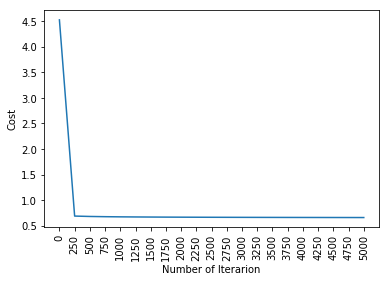

Test Accuracy: 59.47 %
Train Accuracy: 60.34 %


In [12]:
logistic_regression(x_train, y_train, x_test, y_test,learning_rate = 0.002, num_iterations = 5001)

# 7. Applying ANN with Keras

In [13]:
x_train, x_test, y_train, y_test = x_train.T, x_test.T, y_train.T, y_test.T

In [14]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from keras.models import Sequential
from keras.layers import Dense

def build_classifier():
    classifier = Sequential()
    classifier.add(Dense(units = 460, kernel_initializer = "uniform", activation="relu", input_dim = x_train.shape[1]))
    classifier.add(Dense(units = 115, kernel_initializer = "uniform", activation="relu"))
    classifier.add(Dense(units = 6, kernel_initializer = "uniform", activation="relu"))
    classifier.add(Dense(units = 1, kernel_initializer = "uniform", activation="sigmoid"))
    classifier.compile(optimizer="adam", loss = "binary_crossentropy", metrics=["accuracy"])
    return classifier

classifier = KerasClassifier(build_fn = build_classifier,epochs = 100)
accuracies = cross_val_score(estimator = classifier, X = x_train,y= y_train,cv=3)
mean = accuracies.mean()
variance = accuracies.std()
print("Accuracy mean: "+ str(mean))
print("Accuracy variance: "+ str(variance))

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
14697/14697 [==============================] - 6s 429us/step - loss: 0.6932 - acc: 0.4970
Epoch 2/100
14697/14697 [==============================] - 6s 399us/step - loss: 0.6932 - acc: 0.4999
Epoch 3/100
14697/14697 [==============================] - 6s 404us/step - loss: 0.6932 - acc: 0.5004
Epoch 4/100
14697/14697 [==============================] - 6s 391us/step - loss: 0.6932 - acc: 0.5023
Epoch 5/100
14697/14697 [==============================] - 6s 388us/step - loss: 0.6932 - acc: 0.5009
Epoch 6/100
14697/14697 [==============================] - 6s 395us/step - loss: 0.6932 - acc: 0.5023
Epoch 7/100
14697/14697 [==============================] - 6s 409us/step - loss: 0.6932 - acc: 0.5023
Epoch 8/100
14697/14697 [==============================] - 6s 398us/step - loss: 0.6932 - acc: 0.5009
Epoch 9/100
14697/14697 [==============================] - 6s 39

# 8. Applying CNN with Keras

In [15]:
print(x_train.shape)
print(y_train.shape)

(22046, 1840)
(22046, 1)


In [16]:
x_train=x_train.reshape(-1,minh,minv,1)
x_test = x_test.reshape(-1,minh,minv,1)
print("x_train shape:",x_train.shape)
print("x_test shape:",x_test.shape)

x_train shape: (22046, 46, 40, 1)
x_test shape: (5512, 46, 40, 1)


In [17]:
y_train.shape

(22046, 1)

In [18]:
from keras.utils.np_utils import to_categorical
y_train = to_categorical(y_train, num_classes = 2)

In [19]:
y_train.shape

(22046, 2)

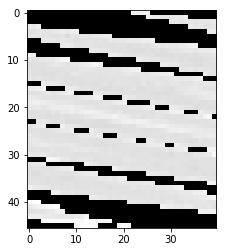

In [20]:
plt.imshow(x_train[0][:,:,0],cmap='gray')
plt.show()

# 9. Conclusion


I hit nearly 60% test accuracy with Logistic Regression method, I think this method don't usefull for this dataset.

With ANN algorithm, I used four layer. Mean accuracy with this method is 65% and it is more succesful than Logistic Regression. Also when we looked into 100th epochs below, we hit 85% success.

I will chance hyperparameters and try to hit 90% accuracy, so this kernel will be updated occasionaly.

When I learn more about Deep Learning, I will try other methods on this kernel.